## Part 0
Read file, data preparation

In [19]:
import pandas as pd
import numpy as np
import csv
import os
import matplotlib.pyplot as plt
import time
import multiprocessing as mp
from extract_parallel import *
%matplotlib inline

# Set Environment variables

In [34]:
FILE_PATH_DIR = '../../../mnt/Data_2TB/TDIResults/PanCancerAtlas/'
REAL_DATA_DIR = FILE_PATH_DIR + 'PanCancer13tts_20171217/'
RAND_DEG_DIR = FILE_PATH_DIR + 'PanCancer13tts_randDEGmatrix_1217'
RAND_SGA_DIR = FILE_PATH_DIR + 'PanCancer13tts_singleSGAs_1217'
sgaFolderList = os.listdir(RAND_SGA_DIR)

POS_FILE_PATH = FILE_PATH_DIR + 'PanCancer13tts_postprobthd.p=0.05.perSGA.csv'

# Extract triplets

Extract real data

In [ ]:
PATH_TDI = REAL_DATA_DIR
PATHNAME_triplet = 'REALtriplet.csv'
extract_file(PATH_TDI, PATHNAME_triplet)
print 'extract' + PATHNAME_triplet + " finished"

Extract DEG rand data

In [ ]:
for i in xrange(1, 4):
    PATH_TDI = RAND_DEG_DIR + '/rand.'+str(i)+'/'    
    PATHNAME_triplet = 'DEGTriplet'+str(i)+'.csv'
    extract_file(PATH_TDI, PATHNAME_triplet)
    print 'extract' + PATHNAME_triplet + " finished"

Extract SGA rand data

In [4]:
for sgaFolder in sgaFolderList:  
    PATH_TDI = RAND_SGA_DIR + '/' + sgaFolder + '/'
    PATHNAME_triplet = 'SGAtriplet' + sgaFolder + '.csv'
    extract_file(PATH_TDI, PATHNAME_triplet)
    print 'extract' + PATHNAME_triplet + " finished"

Total time elapsed SGAtripletCSMD3.csv: 00:02:02

extractSGAtripletCSMD3.csv finished
Total time elapsed SGAtripletZFHX4.csv: 00:01:11

extractSGAtripletZFHX4.csv finished
Total time elapsed SGAtripletTP53.csv: 00:05:41

extractSGAtripletTP53.csv finished
Total time elapsed SGAtripletTTN.csv: 00:03:33

extractSGAtripletTTN.csv finished
Total time elapsed SGAtripletPIK3CA.csv: 00:02:22

extractSGAtripletPIK3CA.csv finished
Total time elapsed SGAtripletPTEN.csv: 00:01:14

extractSGAtripletPTEN.csv finished


# Load data

In [9]:
df_realData = pd.read_csv('REALTriplet.csv')
df_exp1 = pd.read_csv('DEGTriplet.csv')
df_exp2= pd.read_csv('DEGTriplet2.csv')
df_exp3 = pd.read_csv('DEGTriplet3.csv')

In [8]:
df_sgaexp = {}
for sgaFolder in sgaFolderList:
    df_sgaexp[sgaFolder] = pd.read_csv('SGAtriplet' + sgaFolder + '.csv')

## Part 1
Compare highest posterior probability per DEG distribution between real data experiment and 3 random DEG matrix permutation experiments.

Text(0.5,1,u'posterior probability')

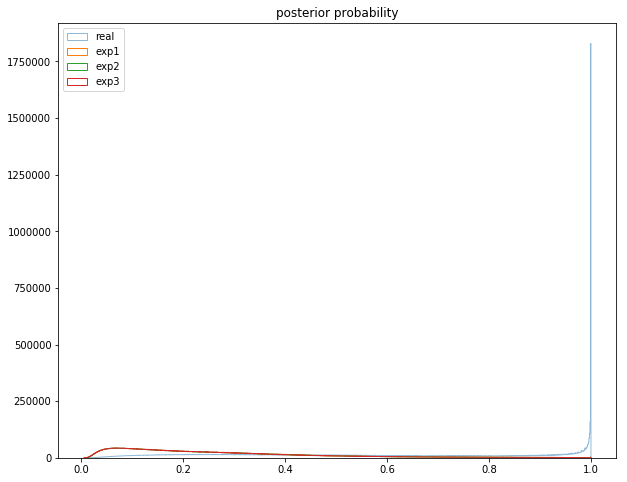

In [22]:
# Plot the distribution of postprob from real data and that from random permutated data (average value) in the same figure.
plt.figure(figsize=(10,8));
plt.hist(df_realData['posterior'], bins=1000, alpha=0.5, histtype='step', label='real')
data_exp1 = plt.hist(df_exp1['posterior'], bins=1000, histtype='step', label='exp1') 
data_exp2 = plt.hist(df_exp2['posterior'], bins=1000, histtype='step', label='exp2')
data_exp3 = plt.hist(df_exp3['posterior'], bins=1000, histtype='step', label='exp3')
plt.legend(loc='upper left')
plt.title('posterior probability')

## Part 2
Compare highest posterior probability per DEG distribution for a given SGA between real data experiment, 3 random DEG matrix permutation experiments and 3 single SGA permutation experiments.

Text(0.5,1,u'posterior probability')

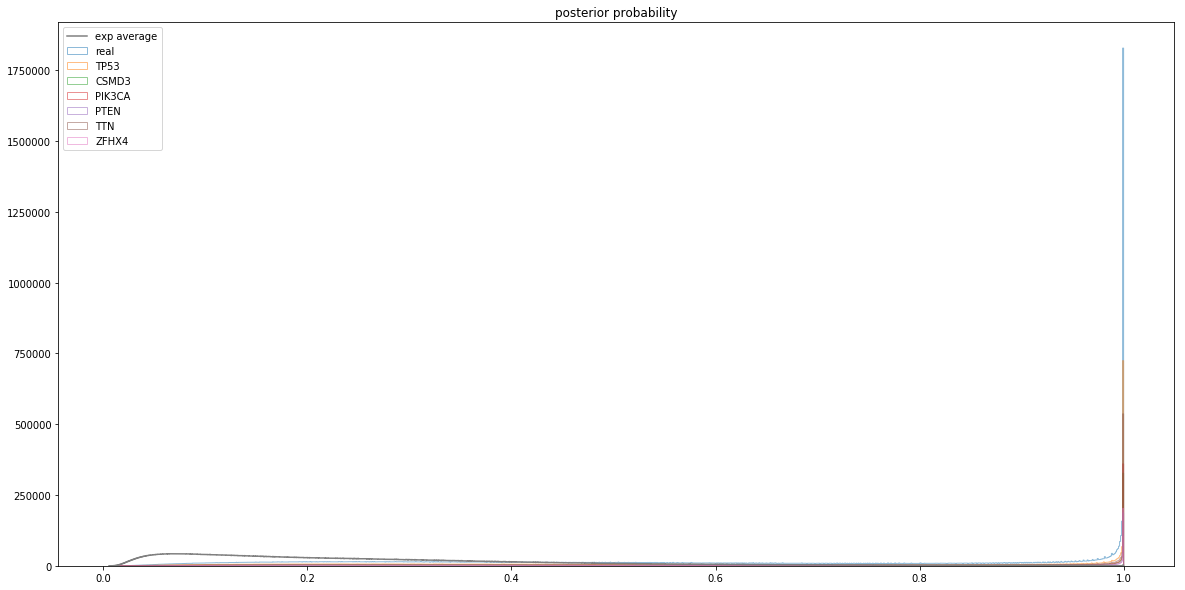

In [32]:
sgas = ['TP53', 'PIK3CA', 'PTEN', 'TTN', 'ZFHX4', 'CSMD3']
subdfs = {}
for sga in sgas:
    subdfs['sga'] = df_realData[df_realData['cause_gene_name'] == sga]

# calculate the average of rand exp histogram
data_exp1 = np.histogram(df_exp1['posterior'], bins=1000) 
data_exp2 = np.histogram(df_exp2['posterior'], bins=1000)
data_exp3 = np.histogram(df_exp3['posterior'], bins=1000)
left, right = data_exp1[1][:-1], data_exp1[1][1:]
X = np.array([left, right]).T.flatten()
Y = np.array([(data_exp1[0] + data_exp2[0] + data_exp3[0])/3, (data_exp1[0] + data_exp2[0] + data_exp3[0])/3]).T.flatten()

# plot histograms
plt.figure(figsize=(20,10))
plt.hist(df_realData['posterior'], bins=1000, alpha=0.5, histtype='step', label='real')
for sga, df_sga in df_sgaexp.iteritems():
    plt.hist(df_sga['posterior'], bins=1000, alpha=0.5, histtype='step', label=sga)
plt.plot(np.append(X,1),np.append(Y, 0), label='exp average')
plt.legend(loc='upper left')
plt.title('posterior probability')

## Part 3
Use 5, 10, 15 DEGs to called driver. Compare the number of drivers per tumor called between real data and random permutated data.

| DEG threshold | 5        | 10    | 15 
| :------------- |:--------| :-----|:------
| real data     | 0.0      | 0.0   |  0.0
| rand exp 1    | 0.0      | 0.0   |  0.0
| rand exp 2    | 0.0      | 0.0   |  0.0
| rand exp 3    | 0.0      | 0.0   |  0.0


In [43]:
%%writefile TDIfuncs.py
def read_file(TRIPLET_FILE_PATH, POS_FILE_PATH):  
    """
        read the tdi file and posterior file 
        return filtered dataframe of tdi results
    """
    # df = pd.read_csv("data_noCT/TSDtriplet.csv")
    # df_posterior = pd.read_csv("data_noCT/PANCAN.postprobcutoff.perSGA.csv")

    df = pd.read_csv(TRIPLET_FILE_PATH)
    df_posterior = pd.read_csv(POS_FILE_PATH)
    tmp = dict(zip(df_posterior['Unnamed: 0'], df_posterior.PostProbcutoff))
    df['a'] = df.cause_gene_name.map(tmp)
    # cutoff by posterior
    df_updated_cutoff = df.loc[df['posterior'] >= df['a']]
    del df_updated_cutoff['a']
    return df_updated_cutoff

def driver(df, threshold=5):
    """
        input: read_file() output
        output: csv file of driver call per tumor
    """
    grouped = df.groupby('patient_name')
    tmp = []
    for name, group in grouped:
        filtergroup = group.groupby('cause_gene_name').filter(lambda x : len(x) >= threshold)
        tmp.append(filtergroup)
    driverTriplet = pd.concat(tmp)
    driverPerTumor = pd.concat(tmp)
    del driverPerTumor['result_gene_name']
    del driverPerTumor['posterior']
    driverPerTumor = driverPerTumor.drop_duplicates()
    return (driverTriplet, driverPerTumor)

def driverCallCompare():
    """
    Result: average number drivers called across all tumors (3x4 table)
    row - number of DEGs used as the threshold, i.e. 5, 10, 15
    column - col1: real data; col2-4: random permutation experiment 1-3.
    """


Writing TDIfuncs.py


In [40]:
TRIPLET_FILE_PATH = 'REALTriplet.csv'
EXP1_FILE_PATH = 'DEGTriplet.csv'
EXP2_FILE_PATH = 'DEGTriplet2.csv'
EXP3_FILE_PATH = 'DEGTriplet3.csv'
POS_FILE_PATH = POS_FILE_PATH
df = read_file(TRIPLET_FILE_PATH, POS_FILE_PATH)

In [ ]:
df_exp1_cutoff = read_file(EXP1_FILE_PATH, POS_FILE_PATH)
df_exp2_cutoff = read_file(EXP2_FILE_PATH, POS_FILE_PATH)
df_exp3_cutoff = read_file(EXP3_FILE_PATH, POS_FILE_PATH)

# call driver(df, 5), driver(df, 10), driver(df, 10)
(driverTriplet_5, driverPerTumor_5) = driver(df, 5)
(driverTriplet_10, driverPerTumor_10) = driver(df, 10)
(driverTriplet_15, driverPerTumor_15) = driver(df, 15)

(driverTriplet_5_exp1, driverPerTumor_5_exp1) = driver(df_exp1_cutoff, 5)
(driverTriplet_10_exp1, driverPerTumor_10_exp1) = driver(df_exp1_cutoff, 10)
(driverTriplet_15_exp1, driverPerTumor_15_exp1) = driver(df_exp1_cutoff, 15)

(driverTriplet_5_exp2, driverPerTumor_5_exp2) = driver(df_exp2_cutoff, 5)
(driverTriplet_10_exp2, driverPerTumor_10_exp2) = driver(df_exp2_cutoff, 10)
(driverTriplet_15_exp2, driverPerTumor_15_exp2) = driver(df_exp2_cutoff, 15)

(driverTriplet_5_exp3, driverPerTumor_5_exp3) = driver(df_exp3_cutoff, 5)
(driverTriplet_10_exp3, driverPerTumor_10_exp3) = driver(df_exp3_cutoff, 10)
(driverTriplet_15_exp3, driverPerTumor_15_exp3) = driver(df_exp3_cutoff, 15)

In [52]:
index = ['real data', 'exp1', 'exp2', 'exp3']
list_5 = [driverPerTumor_5.groupby('patient_name').count().mean()[0],driverPerTumor_5_exp1.groupby('patient_name').count().mean()[0],driverPerTumor_5_exp2.groupby('patient_name').count().mean()[0],driverPerTumor_5_exp3.groupby('patient_name').count().mean()[0]]
list_10 = [driverPerTumor_10.groupby('patient_name').count().mean()[0],driverPerTumor_10_exp1.groupby('patient_name').count().mean()[0],driverPerTumor_10_exp2.groupby('patient_name').count().mean()[0],driverPerTumor_10_exp3.groupby('patient_name').count().mean()[0]]
list_15 = [driverPerTumor_15.groupby('patient_name').count().mean()[0],driverPerTumor_15_exp1.groupby('patient_name').count().mean()[0],driverPerTumor_15_exp2.groupby('patient_name').count().mean()[0],driverPerTumor_15_exp3.groupby('patient_name').count().mean()[0]]

result = pd.DataFrame({5:list_5,
                      10:list_10,
                      15:list_15}, index = index)

In [54]:
print "average number of driver call in each tumor"
result

average number of driver call in each tumor


,5,10,15
real data,30.484206,19.059251,14.358979
exp1,8.758984,4.967717,3.338389
exp2,8.734319,4.962098,3.310700
exp3,8.641045,4.920061,3.328240


## Part 4
Use 5, 10, 15 DEGs to called driver for a given SGA. Compare the number of tumors the given SGA is called as a driver in real data, 3 random DEG permutated data and single SGA permutated data.

In [68]:
# variables
sgas = ['TP53', 'PIK3CA', 'PTEN', 'TTN', 'ZFHX4', 'CSMD3']

In [69]:
lists = {}
for sga in sgas:
    lists[sga] = [len(driverPerTumor_5[driverPerTumor_5.cause_gene_name == sga]['patient_name']),
                  len(driverPerTumor_5[driverPerTumor_5.cause_gene_name == sga]['patient_name']),
                  len(driverPerTumor_5[driverPerTumor_5.cause_gene_name == sga]['patient_name']),
                  len(driverPerTumor_5_exp1[driverPerTumor_5_exp1.cause_gene_name == sga]['patient_name']),
                  len(driverPerTumor_5_exp1[driverPerTumor_5_exp1.cause_gene_name == sga]['patient_name']),
                  len(driverPerTumor_5_exp1[driverPerTumor_5_exp1.cause_gene_name == sga]['patient_name']),
                  len(driverPerTumor_5_exp2[driverPerTumor_5_exp2.cause_gene_name == sga]['patient_name']),
                  len(driverPerTumor_5_exp2[driverPerTumor_5_exp2.cause_gene_name == sga]['patient_name']),
                  len(driverPerTumor_5_exp2[driverPerTumor_5_exp2.cause_gene_name == sga]['patient_name']),
                  len(driverPerTumor_5_exp3[driverPerTumor_5_exp3.cause_gene_name == sga]['patient_name']),
                  len(driverPerTumor_5_exp3[driverPerTumor_5_exp3.cause_gene_name == sga]['patient_name']),
                  len(driverPerTumor_5_exp3[driverPerTumor_5_exp3.cause_gene_name == sga]['patient_name']),
                 ]
index=['real data 5', 'real data 10', 'real data 15', 'exp1_5', 'exp1_10', 'exp1_15', 'exp2_5', 'exp2_10', 'exp2_15', 'exp3_5', 'exp3_10', 'exp3_15']
result = pd.DataFrame(lists, index = index)

In [70]:
result

,CSMD3,PIK3CA,PTEN,TP53,TTN,ZFHX4
real data 5,909,1054,580,2235,1317,553
real data 10,909,1054,580,2235,1317,553
real data 15,909,1054,580,2235,1317,553
exp1_5,3,31,12,6,0,1
exp1_10,3,31,12,6,0,1
exp1_15,3,31,12,6,0,1
exp2_5,5,30,11,6,0,5
exp2_10,5,30,11,6,0,5
exp2_15,5,30,11,6,0,5
exp3_5,2,33,32,6,0,3


## Part 5
Calculate average driver call rate for well known drivers collected from Kandoth and Lawrence papers. What percentage of well known drivers are called as TDI drivers in at least one tumor? (Use 5, 10, 15 DEGs to called driver.)

In [9]:
files = [f for f in os.listdir('.') if os.path.isfile(f)]